In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("data_cleaned.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      397924 non-null  int64  
 1   StockCode      397924 non-null  object 
 2   Description    397924 non-null  object 
 3   Quantity       397924 non-null  int64  
 4   InvoiceDate    397924 non-null  object 
 5   UnitPrice      397924 non-null  float64
 6   CustomerID     397924 non-null  float64
 7   Country        397924 non-null  object 
 8   Sales          397924 non-null  float64
 9   Category_Name  397924 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 30.4+ MB


In [5]:
import datetime

# Convert InvoiceDate column to datetime format

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Bugünün tarihi
today_date = data["InvoiceDate"].max() + datetime.timedelta(days=1)
print(today_date)

2011-12-10 12:50:00


In [6]:
# Create Total Sales Column

data["TotalSales"] = data["Quantity"] * data["UnitPrice"]


In [7]:
# Calculate RFM metrics

rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (today_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalSales": "sum"  # Monetary
}).rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalSales": "Monetary"})

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [8]:
# Reverse sort for Recency (lowest to best)

rfm["R"] = pd.qcut(rfm["Recency"], q=5, labels=[5, 4, 3, 2, 1])

# Sorting for Frequency and Monetary (highest to best)

rfm["F"] = pd.qcut(rfm["Frequency"].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5])
rfm["M"] = pd.qcut(rfm["Monetary"].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5])

# Merge RFM Score

rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,19,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


In [9]:
# Eğer 'CustomerID' index'te ise, onu kolona dönüştür
rfm.reset_index(inplace=True)

In [10]:
def segment_rfm(score):
    if score == "555":
        return "VIP Customer"
    elif score[0] == "5":
        return "Loyal Customer"
    elif score[1] == "5":
        return "Frequent Shopper"
    elif score[2] == "5":
        return "Big Spender"
    elif score[0] == "1":
        return "Lost Customer"
    else:
        return "Mid-Level Customer"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_rfm)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Big Spender
1,12347.0,2,7,4310.00,5,5,5,555,VIP Customer
2,12348.0,75,4,1797.24,2,4,4,244,Mid-Level Customer
3,12349.0,19,1,1757.55,4,1,4,414,Mid-Level Customer
4,12350.0,310,1,334.40,1,1,2,112,Lost Customer


In [11]:
# Eğer 'CustomerID' verisinde mevcutsa ve 'customerID' olarak düzenlemek istersen
rfm["CustomerID"] = rfm["CustomerID"]  # 'CustomerID' kolonunu müşteri kimliği olarak kullan

# Segmentasyon ve diğer hesaplamaları yap
rfm["Segment"] = rfm["RFM_Score"].apply(segment_rfm)

# Veriyi kaydet (Müşteri kimliği ile birlikte diğer tüm kolonlar)
#rfm.to_csv("rfm_with_segments_and_customer_id.csv", index=False)

# İlk birkaç satırı kontrol et
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Score  \
0     12346.0      326          1  77183.60  1  1  5       115   
1     12347.0        2          7   4310.00  5  5  5       555   
2     12348.0       75          4   1797.24  2  4  4       244   
3     12349.0       19          1   1757.55  4  1  4       414   
4     12350.0      310          1    334.40  1  1  2       112   

              Segment  
0         Big Spender  
1        VIP Customer  
2  Mid-Level Customer  
3  Mid-Level Customer  
4       Lost Customer  


In [12]:
# İlk birkaç satırı kontrol et
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Score  \
0     12346.0      326          1  77183.60  1  1  5       115   
1     12347.0        2          7   4310.00  5  5  5       555   
2     12348.0       75          4   1797.24  2  4  4       244   
3     12349.0       19          1   1757.55  4  1  4       414   
4     12350.0      310          1    334.40  1  1  2       112   

              Segment  
0         Big Spender  
1        VIP Customer  
2  Mid-Level Customer  
3  Mid-Level Customer  
4       Lost Customer  


In [13]:
# Segmentasyonu yap ve Segment kolonunu ekle
rfm["Segment"] = rfm["RFM_Score"].apply(segment_rfm)

# Tüm kolonları kontrol et
print(rfm.columns)

# Veriyi kaydet (R, F, M, RFM_Score ve Segment dahil)
rfm.to_csv("RFM.csv", index=False)

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M',
       'RFM_Score', 'Segment'],
      dtype='object')


# Customer Segmentation Based on RFM Analysis

## 🔥 1. VIP Customers (RFM Score: 555)
**Characteristics:** Customers who have shopped most recently, shop most frequently, and spend the most.

**Insight:** These customers are the most valuable group for the brand. To retain them:

- ✅ Offer special discounts and VIP programs.
- ✅ Reach out with personalized email campaigns or offers to increase loyalty.
- ✅ Provide exclusive products or early access opportunities.

**🎯 Strategy:** "Offer exclusive deals and privileged services to ensure you don't lose these customers!"

---

## 🔄 2. Loyal Customers (RFM Score: 5XX)
**Characteristics:** Customers who shop frequently but have variable spending amounts.

**Insight:** These customers already shop regularly, but you can encourage them to spend more.

- ✅ Implement a points system to incentivize more purchases.
- ✅ Use cross-selling strategies (e.g., recommend related products).
- ✅ Offer free shipping or small gifts to motivate them.

**🎯 Strategy:** "Create incentive systems to encourage them to spend more!"

---

## 💰 3. Big Spenders (RFM Score: XX5)
**Characteristics:** Customers who spend a lot but may shop infrequently.

**Insight:** These customers make high-value purchases but may only shop once or twice a year.

- ✅ Encourage repeat purchases: "Get 20% off on your next purchase!"
- ✅ Encourage them to join loyalty programs.
- ✅ Offer premium content or personal assistant services.

**🎯 Strategy:** "Increase their shopping frequency to turn them into loyal customers!"

---

## ⚠️ 4. Lost Customers (RFM Score: 1XX)
**Characteristics:** Customers who haven't shopped in a long time, shop infrequently, and spend little.

**Insight:** To win back these customers, create re-engagement campaigns.

- ✅ Send personalized email campaigns like "We missed you! Come back with 30% off!"
- ✅ Send reminder notifications to old customers.
- ✅ Analyze the reason: Why did they stop shopping? Price? Product? Service?

**🎯 Strategy:** "Try to win them back and reduce churn rate!"

---

## ⏳ 5. Potential Loyal Customers (RFM Score: 5X5)
**Characteristics:** New customers who have made high-value purchases but haven't shopped frequently yet.

**Insight:** If guided well, these customers can become loyal.

- ✅ Offer incentives like "Get an extra 10% off on your next purchase!"
- ✅ Send personalized recommendations via email.
- ✅ Provide fast shipping and excellent customer service to increase satisfaction.

**🎯 Strategy:** "Pay extra attention to turn these customers into loyal ones!"

C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_8564\2098783258.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=rfm["Segment"], order=rfm["Segment"].value_counts().index, palette="coolwarm")


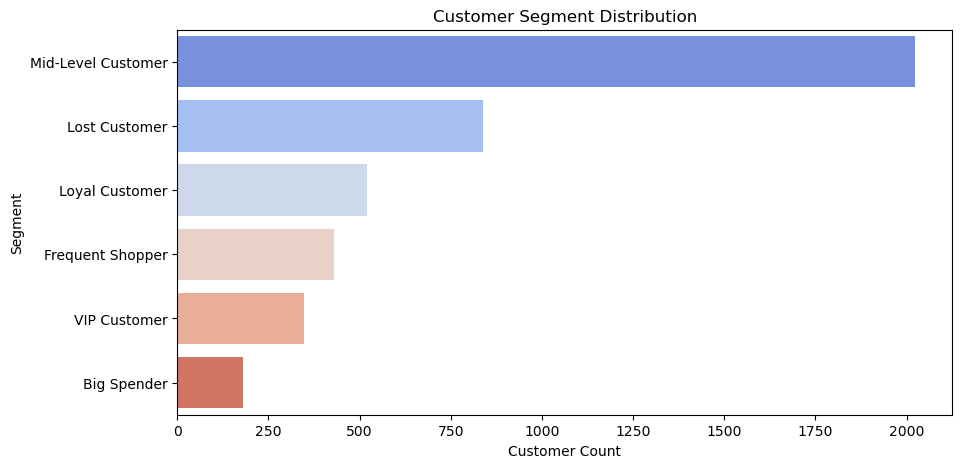

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(y=rfm["Segment"], order=rfm["Segment"].value_counts().index, palette="coolwarm")
plt.title("Customer Segment Distribution")
plt.xlabel("Customer Count")
plt.ylabel("Segment")
plt.show()


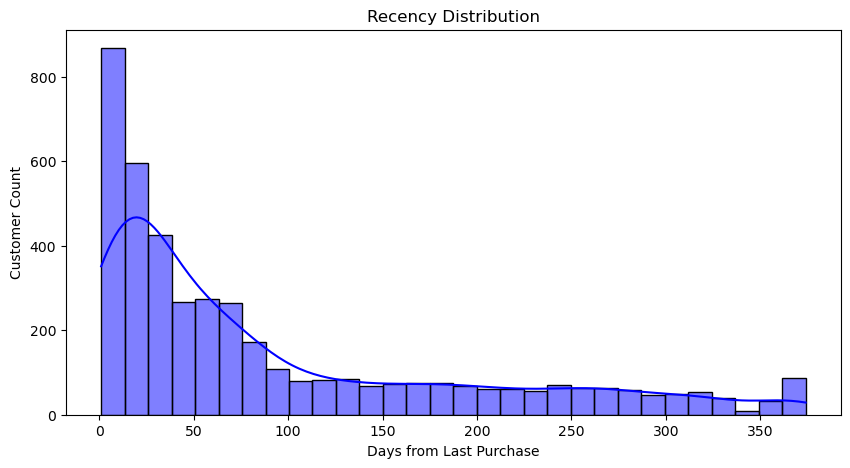

In [15]:
# Recency distribution with histogram

plt.figure(figsize=(10, 5))
sns.histplot(rfm["Recency"], bins=30, kde=True, color="blue")
plt.title("Recency Distribution")
plt.xlabel("Days from Last Purchase")
plt.ylabel("Customer Count")
plt.show()


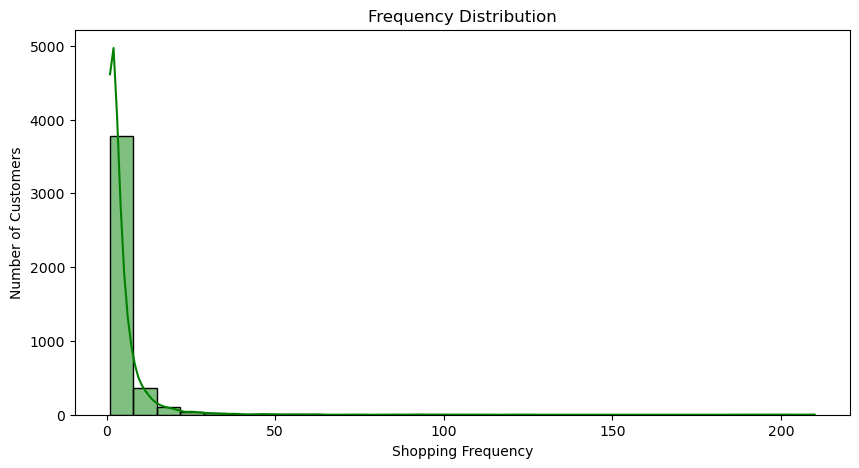

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm["Frequency"], bins=30, kde=True, color="green")
plt.title("Frequency Distribution")
plt.xlabel("Shopping Frequency")
plt.ylabel("Number of Customers")
plt.show()


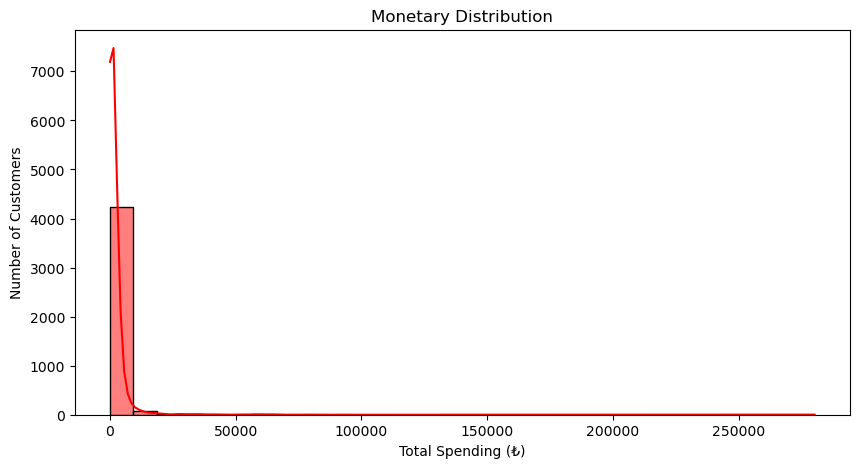

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm["Monetary"], bins=30, kde=True, color="red")
plt.title("Monetary Distribution")
plt.xlabel("Total Spending (₺)")
plt.ylabel("Number of Customers")
plt.show()


In [18]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])


Recency        Frequency            Monetary      
                          mean count       mean count          mean count
Segment                                                                  
Big Spender          76.187845   181   3.640884   181   4236.597243   181
Frequent Shopper     46.081585   429   9.361305   429   4294.455501   429
Lost Customer       269.295102   837   1.378734   837    385.836691   837
Loyal Customer        6.651923   520   3.771154   520   1459.748096   520
Mid-Level Customer   67.749012  2024   2.171937  2024    649.744152  2024
VIP Customer          5.445402   348  18.247126   348  11221.741121   348

C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_8564\2745687885.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)


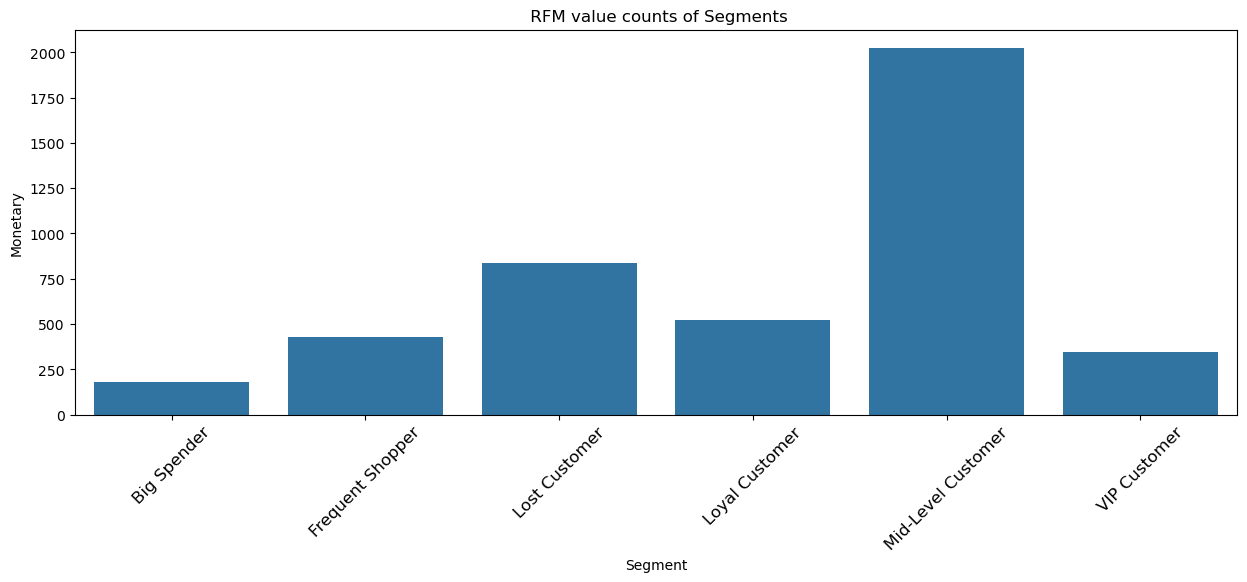

In [19]:
eda = rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg("count")
     

eda.reset_index(inplace=True)
     

def count_rfm(DataFrame): 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Segment', y='Monetary', data=eda)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    plt.title(" RFM value counts of Segments")
count_rfm(eda)

C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_8564\2257766120.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)


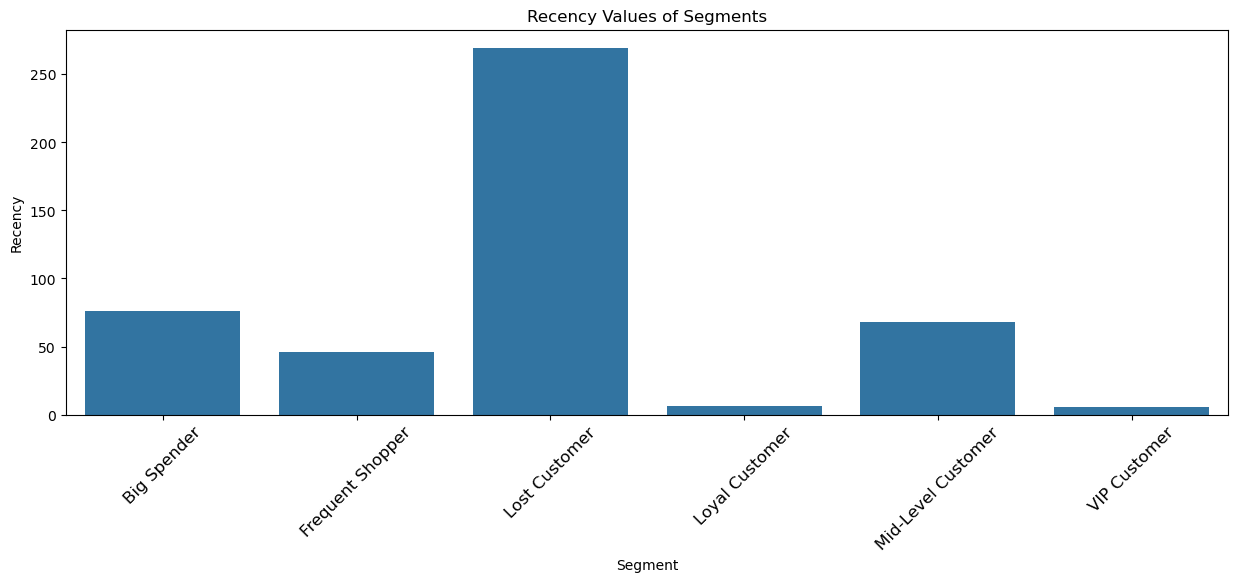

In [20]:
eda_3 = rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg("mean")

     

eda_3.reset_index(inplace=True)
     

def mean_recency(DataFrame): # average recency values ​​of each segment
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Segment', y='Recency', data=eda_3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    plt.title("Recency Values of Segments")
mean_recency(eda_3)
     

In [21]:
import squarify

In [22]:
square_rfm = rfm.copy()

In [23]:
square_rfm.reset_index(inplace=True)


In [24]:
square_rfm.columns

Index(['index', 'CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F',
       'M', 'RFM_Score', 'Segment'],
      dtype='object')

In [25]:
square_rfm = square_rfm.groupby("Segment")["CustomerID"].nunique().sort_values(ascending=False).reset_index()


In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Creating color map and norm

cmap = plt.cm.Oranges_r
mini = min(square_rfm["CustomerID"])
maxi = max(square_rfm["CustomerID"])
norm = mcolors.Normalize(vmin=mini, vmax=maxi)


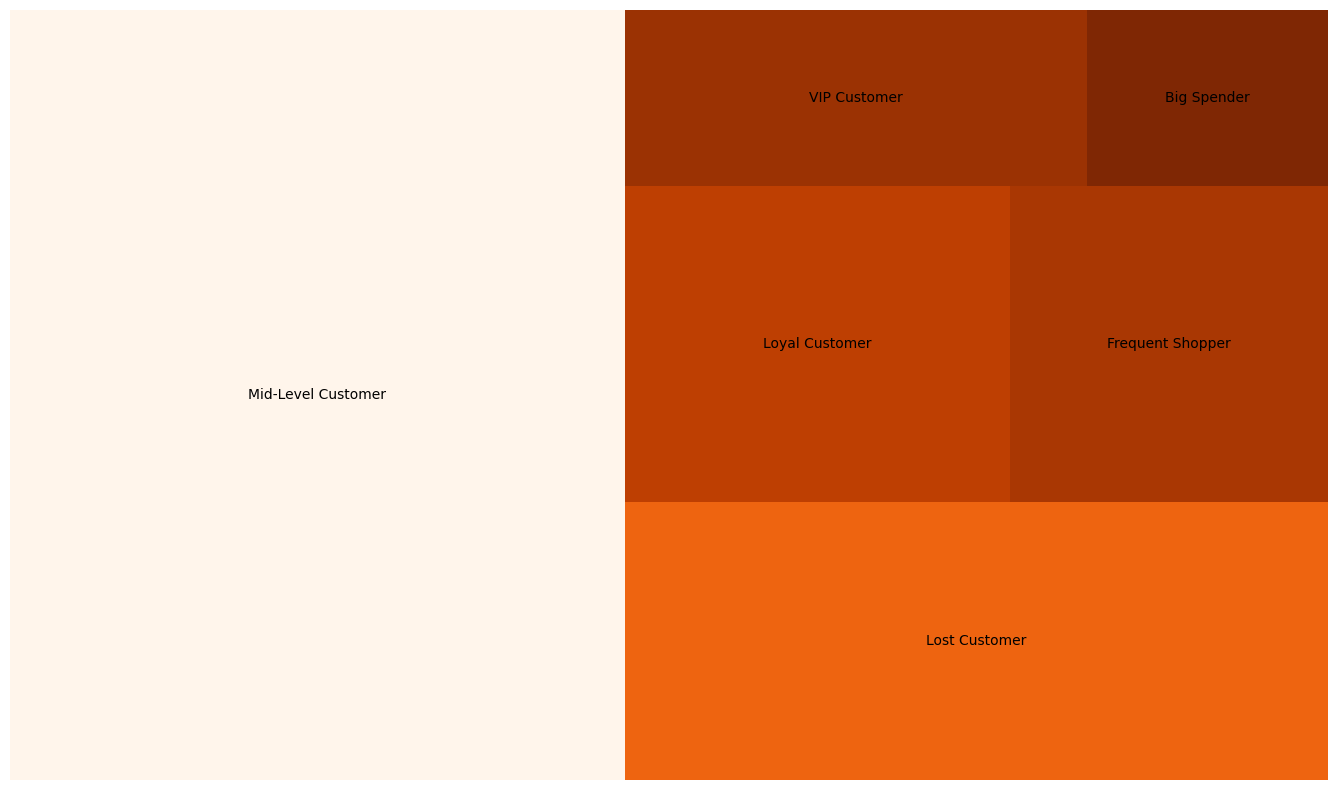

In [27]:
colors = [cmap(norm(value)) for value in square_rfm['CustomerID']]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(17,10)
squarify.plot(sizes = square_rfm['CustomerID'], color = colors, label = square_rfm['Segment'], alpha=1)
plt.axis('off')
plt.show()

In [28]:
rfm.to_csv('rfm.csv', index=False)
